In [112]:
import json
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
from tqdm import tqdm
import requests
import textwrap
import xmltodict
from wordcloud import WordCloud

%reload_ext autoreload
%autoreload 2
sys.path.append('../scripts')
import pbmd_tools as pbmd

In [32]:
pbmd.read_tokens("../.env")
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
PUBMED_TOKEN = os.environ.get("PUBMED_TOKEN")

## Last commit analysis

In [57]:
df = pd.read_csv('../data/articles.tsv', sep='\t')
PMIDs = df['PMID'][df['Repo_created_at'].notna()].to_list()
len(PMIDs)

10122

In [107]:
for PMID in tqdm(PMIDs):
    
    last_commit_files = ''
    files, status = pbmd.get_last_commit_files(df[df['PMID']==PMID]['GitHub_owner'].values[0], 
                                       df[df['PMID']==PMID]['GitHub_repo'].values[0], 
                                       GITHUB_TOKEN)
    if status == 403:
        time.sleep(3600)
    
    if status != 200 and status != 403:
        with open("../data/otherstat.txt", "a") as f:
            f.write(f"\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['GitHub_link_clean'].values[0]}, Error: {status}")
        
    if files != None:
        for file in files:
            last_commit_files += f"{file}, "

            idx = df.index[df['PMID'] == PMID][0]
            df.loc[idx, "Last_commit"] = last_commit_files
    else:
        with open("../data/otherstat.txt", "a") as f:
            f.write(f"\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['GitHub_link_clean'].values[0]}")


100%|████████████████████████████████████████████████████████████████████████████████| 159/159 [02:47<00:00,  1.05s/it]


In [108]:
df[df['Last_commit'].isna()][df['Repo_created_at'].notna()]

C:\Users\nadia\AppData\Local\Temp\ipykernel_2352\3516920919.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['Last_commit'].isna()][df['Repo_created_at'].notna()]


,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,GitHub_owner,GitHub_repo,Repo_created_at,Repo_updated_at,Fork,In_SoftWH,Archived,Last_commit
527,31110304,2019-05-20,10.1038/s41598-019-43935-8,Scientific reports,GREIN: An Interactive Web Platform for Re-anal...,The vast amount of RNA-seq data deposited in G...,github.com/uc-bd2k/grein,https://github.com/uc-bd2k/grein/,uc-bd2k,grein,2017-06-14,2023-03-22,0.0,0.0,NaN,NaN
650,32348298,2020-04-29,10.1371/journal.pcbi.1007847,PLoS computational biology,Medusa: Software to build and analyze ensemble...,Uncertainty in the structure and parameters of...,github.com/opencobra/Medusa,https://github.com/opencobra/Medusa/,opencobra,Medusa,2017-09-18,2022-12-28,0.0,0.0,NaN,NaN
963,34158502,2021-06-22,10.1038/s41467-021-24041-8,Nature communications,Comprehensive identification of transposable e...,Transposable elements (TEs) help shape the str...,github.com/parklab/xTea,https://github.com/parklab/xTea/,parklab,xTea,2018-07-12,2023-04-09,0.0,1.0,2023-04-16,NaN
1153,35544507,2022-05-18,10.1109/TIP.2022.3172845,IEEE transactions on image processing : a publ...,Deepfake Forensics via an Adversarial Game.,With the progress in AI-based facial forgery (...,github.com/ah651/deepfake_adv.,https://github.com/ah651/deepfake_adv/,ah651,deepfake_adv,2022-04-18,2022-10-02,0.0,0.0,NaN,NaN
1155,37015702,2022-12-12,10.1109/JBHI.2022.3228341,IEEE journal of biomedical and health informatics,A Hierarchical Attention-Based Method for Slee...,Sleep monitoring typically requires the uncomf...,github.com/scutrd/attention-sleep-staging.,https://github.com/scutrd/attention-sleep-stag...,scutrd,attention-sleep-staging,2022-12-05,2022-12-05,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10265,33677485,2021-09-09,10.1093/bioinformatics/btab145,"Bioinformatics (Oxford, England)",NIBNA: a network-based node importance approac...,"[OrderedDict([('@Label', 'MOTIVATION'), ('@Nlm...",github.com/mandarsc/NIBNA.,https://github.com/mandarsc/NIBNA/,mandarsc,NIBNA,2020-02-14,2021-08-22,0.0,0.0,NaN,NaN
10314,29228182,2018-04-01,10.1093/bioinformatics/btx776,"Bioinformatics (Oxford, England)",PEITH(Θ): perfecting experiments with informat...,"[OrderedDict([('@Label', 'MOTIVATION'), ('#tex...",github.com/MichaelPHStumpf/Peitho.,https://github.com/MichaelPHStumpf/Peitho/,MichaelPHStumpf,Peitho,2017-08-04,2018-01-05,0.0,1.0,2021-01-02,NaN
10624,36205607,2022-11-30,10.1093/bioinformatics/btac666,"Bioinformatics (Oxford, England)",MDSCAN: RMSD-based HDBSCAN clustering of long ...,"[OrderedDict([('@Label', 'MOTIVATION'), ('#tex...",github.com/LQCT/MDScan.git,https://github.com/LQCT/MDScan/,LQCT,MDScan,2021-01-12,2023-02-24,0.0,0.0,NaN,NaN
10699,36349348,2022-06-23,NaN,The journal of machine learning for biomedical...,Joint Frequency and Image Space Learning for M...,We propose neural network layers that explicit...,github.com/nalinimsingh/interlacer.,https://github.com/nalinimsingh/interlacer/,nalinimsingh,interlacer,2019-04-18,2023-02-17,0.0,0.0,NaN,NaN


In [110]:
file_names_list = []
for line in df['Last_commit'][df['Last_commit'].notna()]:
    commits = [commit.strip().split('/')[-1].split('.')[-2].strip() if '.' in commit.strip().split('/')[-1] else commit.strip().split('/')[-1].strip() for commit in line.split(',')]
    for commit in commits:
        if commit != '':
            file_names_list.append(commit)

In [111]:
file_names_lower = [name.lower() for name in file_names_list]

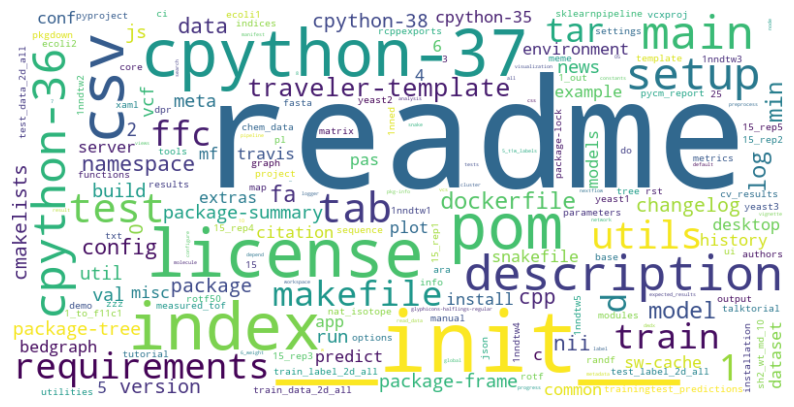

In [114]:
word_frequencies = {}
for file_name in file_names_lower:
    if file_name in word_frequencies:
        word_frequencies[file_name] += 1
    else:
        word_frequencies[file_name] = 1

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


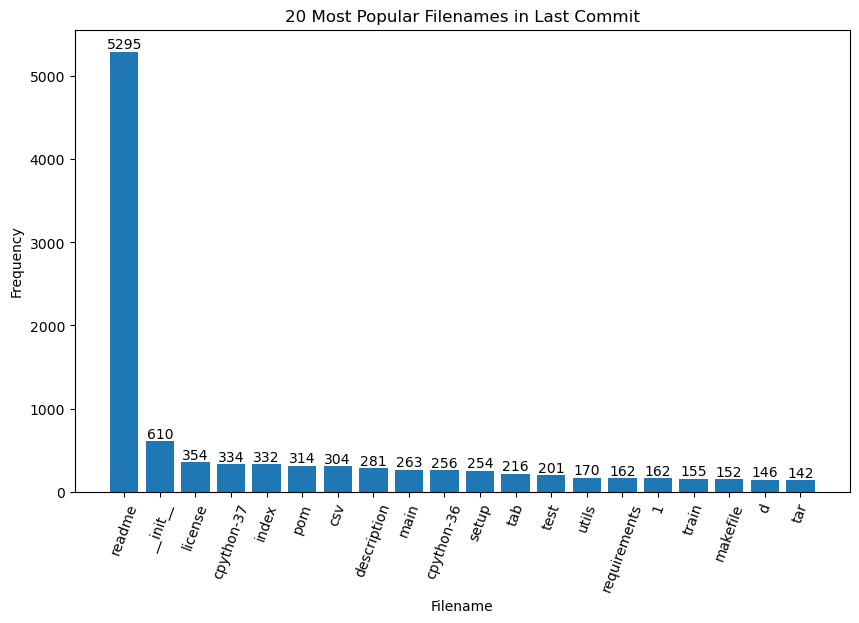

In [115]:
n = 20

df_files = pd.DataFrame(file_names_lower, columns=['Filename'])
filename_counts = df_files['Filename'].value_counts()
top_filenames = filename_counts.head(n)

plt.figure(figsize=(10, 6))

bars = plt.bar(top_filenames.index, top_filenames.values)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom')

plt.xticks(rotation=70)
plt.xlabel('Filename')
plt.ylabel('Frequency')
plt.title(f'{n} Most Popular Filenames in Last Commit')

plt.show()


In [123]:
df['Readme'] = df['Last_commit'].apply(lambda x: 1 if str(x).lower() == 'readme.md, ' or str(x).lower() == 'readme.rmd, ' or str(x).lower() == 'readme.rst, ' else 0)

In [124]:
sum(df['Readme'] == 1)

3859

In [125]:
df.to_csv("../data/last_commit.csv")

# A large-scale analysis of bioinformatics code on GitHub
### DOI: 10.1371/journal.pone.0205898

In [6]:
url = 'https://doi.org/10.1371/journal.pone.0205898.s005'
response = requests.get(url)
with open(f"../data/{url.split('/')[3]}.xlsx", 'wb') as f:
    f.write(response.content)

df = pd.read_excel(f"../data/{url.split('/')[3]}.xlsx")

In [16]:
df = df[df['use_repo']==1]
len(df)

1720

In [19]:
df['GitHub_owner'] = df['repo_name'].apply(lambda x: x.split('/')[0])
df['GitHub_repo'] = df['repo_name'].apply(lambda x: x.split('/')[1])
df['GitHub_link']= df['repo_name'].apply(lambda x: 'https://github.com/' + str(x) + '/')

In [18]:
for num in tqdm(df.iloc[:, 0].to_list()):

    info = pbmd.get_repo_info(df[df.iloc[:, 0]==num]['GitHub_owner'].values[0], df[df.iloc[:, 0]==num]['GitHub_repo'].values[0], GITHUB_TOKEN, "stat.txt")

    if info["status"]: 
        idx = df.index[df.iloc[:, 0]==num][0]

        df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
        df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
        df.loc[idx, "Fork"] = pbmd.is_fork(info)


100%|██████████| 1720/1720 [08:22<00:00,  3.42it/s]


In [22]:
for num in tqdm(df.iloc[:, 0].to_list()):

    info = pbmd.check_is_in_softwh(df[df.iloc[:, 0]==num]['GitHub_link'].values[0])

    idx = df.index[df.iloc[:, 0]==num][0]

    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|██████████| 1720/1720 [03:26<00:00,  8.34it/s]


In [23]:
len(set(df[df['In_SoftWH'] == 1][df['use_repo'] == 1]['repo_name'].to_list()))

<ipython-input-23-7f8a08a9cd80>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['In_SoftWH'] == 1][df['use_repo'] == 1]['repo_name'].to_list()))


1632

In [24]:
len(set(df[df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))

<ipython-input-24-82aaf8ff4134>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))


88

In [25]:
len(set(df[df['Repo_created_at'].isna()][df['use_repo'] == 1]['repo_name'].to_list()))

<ipython-input-25-214bd0e691a8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['Repo_created_at'].isna()][df['use_repo'] == 1]['repo_name'].to_list()))


18

In [26]:
len(set(df[df['Repo_created_at'].isna()][df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))

<ipython-input-26-0b846f606168>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['Repo_created_at'].isna()][df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))


0

In [28]:
df.to_csv('../data/file_info.tsv', sep='\t', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/articles.tsv'

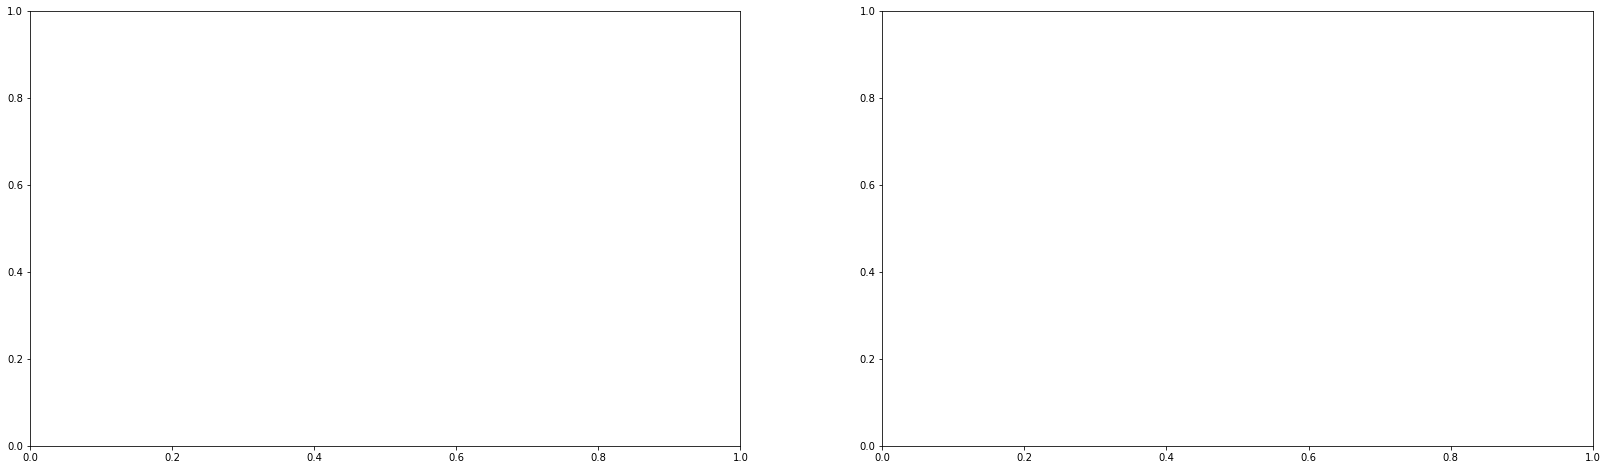

In [31]:
fig, ax = plt.subplots(1,2, figsize=(28, 8))

df = pd.read_csv('../data/articles.tsv', sep='\t')
journals_article = df['Journal'].value_counts().to_dict()
journals = list(journals_article.keys())[:20]
values = list(journals_article.values())[:20]
wrapped_labels = [textwrap.fill(label, 50) for label in journals]

ax[0].bar(journals, values, color='#225ea8')
ax[0].set_xticklabels(wrapped_labels, rotation=70, ha='right')
ax[0].tick_params(axis='y', labelsize=12) 
ax[0].tick_params(axis='x', labelsize=12) 

df = pd.read_csv('file.csv', sep=',')
df.loc[df['journal'] == 'PLoS Comput Biol', 'journal'] = 'PLoS Computational Biology'
df.loc[df['journal'] == 'BMC bioinformatics', 'journal'] = 'BMC Bioinformatics'
df.loc[df['journal'] == 'Nucleic Acids Res', 'journal'] = 'Nucleic Acids Research'
df.loc[df['journal'] == 'Genome Biol', 'journal'] = 'Genome Biology'
df = df[df['use_repo'] == 1]
journals_article = df['journal'].value_counts().to_dict()
journals = list(journals_article.keys())[:20]
values = list(journals_article.values())[:20]
wrapped_labels = [textwrap.fill(label, 50) for label in journals]

ax[1].bar(journals, values, color='#225ea8')
ax[1].set_xticklabels(wrapped_labels, rotation=70, ha='right')
ax[1].tick_params(axis='y', labelsize=12) 
ax[1].tick_params(axis='x', labelsize=12) 


plt.show()

In [ ]:
df = pd.read_csv('../data/file_info.tsv', sep='\t')
df = df[df['use_repo'] == 1]

fig, ax = plt.subplots(figsize=(10, 7))

df_grouped = df.groupby([df['year']]).size().reset_index(name='count')
ax.bar(list(set(df['year'].to_list())), df_grouped['count'], color='#41b6c4')

df_grouped = df.groupby([df['year'], 'In_SoftWH']).size().reset_index(name='count')
df_softwh = df_grouped[df_grouped['In_SoftWH'] == 1]

ax.bar(list(set(df['year'].to_list())), df_softwh['count'], color='#a1dab4')

ax.set_xlabel('Year', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.legend([f"Not in Software Heritage ({sum(df_grouped['count']) - sum(df_softwh['count'])})", 
           f"In Software Heritage ({sum(df_softwh['count'])})"], fontsize=12)

plt.xticks(list(set(df['year'].to_list())), rotation=70)
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='x', labelsize=12) 

plt.show()


# BMC bioinformatics statistics

In [35]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries = []
queries_github = []
queries_forges = []
for year in range(2009, 2023):
    queries.append(f'(("BMC bioinformatics"[Journal])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_github.append(f'(("BMC bioinformatics"[Journal])) AND ((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_forges.append(f'(("BMC bioinformatics"[Journal])) AND ((("//gitlab."[Title/Abstract])) OR (("sourceforge.net"[Title/Abstract])) OR ("googlecode") OR ("bitbucket.org"[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [36]:
PMIDs_in_journal = []
PMIDs_forges = []
PMIDs_with_link = []

stats_in_journal = pbmd.get_forges_stat(queries, PMIDs_in_journal)
stats_forges = pbmd.get_forges_stat(queries_forges, PMIDs_forges)
stats_with_link = pbmd.get_forges_stat(queries_github, PMIDs_with_link)

100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


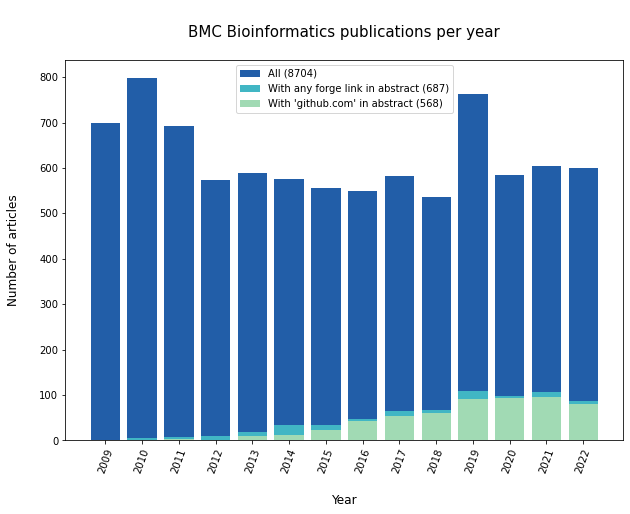

In [37]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2009, 2023))
values_journal = list(stats_in_journal.values())
values_links = list(stats_with_link.values())
values_forges = list(stats_forges.values())

for i in range(14):
    values_forges[i] += values_links[i]

ax.bar(years, values_journal, color='#225ea8')
ax.bar(years, values_forges, color='#41b6c4')
ax.bar(years, values_links, color='#a1dab4')

ax.legend([f"All ({sum(values_journal)})", 
           f"With any forge link in abstract ({sum(values_forges)})",
           f"With 'github.com' in abstract ({sum(values_links)})"], loc = 'upper center')

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('\nBMC Bioinformatics publications per year\n', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.show()

# Bioinformatics statistics

In [32]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries = []
queries_github = []
queries_forges = []
for year in range(2009, 2023):
    queries.append(f'(("Bioinformatics"[Journal])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_github.append(f'(("Bioinformatics"[Journal])) AND ((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_forges.append(f'(("Bioinformatics"[Journal])) AND ((("gitlab"[Title/Abstract])) OR (("sourceforge.net"[Title/Abstract])) OR ("googlecode") OR ("bitbucket.org"[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [33]:
PMIDs_in_journal = []
PMIDs_forges = []
PMIDs_with_link = []

stats_in_journal = pbmd.get_forges_stat(queries, PMIDs_in_journal)
stats_forges = pbmd.get_forges_stat(queries_forges, PMIDs_forges)
stats_with_link = pbmd.get_forges_stat(queries_github, PMIDs_with_link)

100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


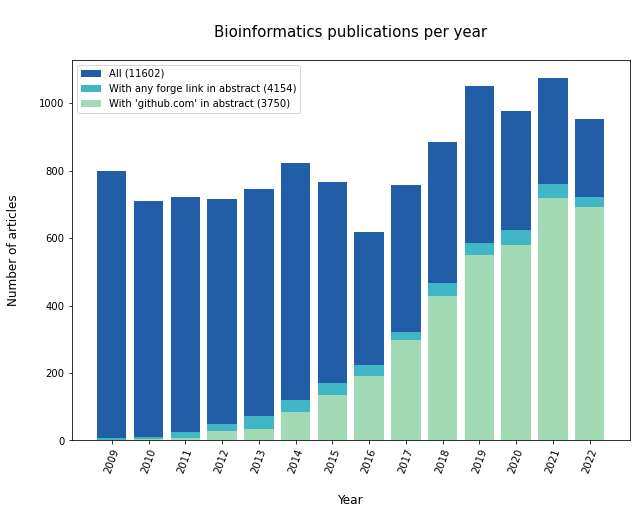

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2009, 2023))
values_journal = list(stats_in_journal.values())
values_links = list(stats_with_link.values())
values_forges = list(stats_forges.values())

for i in range(14):
    values_forges[i] += values_links[i]

ax.bar(years, values_journal, color='#225ea8')
ax.bar(years, values_forges, color='#41b6c4')
ax.bar(years, values_links, color='#a1dab4')

ax.legend([f"All ({sum(values_journal)})", 
           f"With any forge link in abstract ({sum(values_forges)})",
           f"With 'github.com' in abstract ({sum(values_links)})"], loc = 'upper left')

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('\nBioinformatics publications per year\n', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.show()

# GitLab statistics

In [48]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries_gitlab = []
for year in range(2014, 2023):
    queries_gitlab.append(f'("gitlab") AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [49]:
stats_gitlab = {}
PMIDs_gitlab = {'2014': [], '2015': [], '2016': [],'2017': [],'2018': [],'2019': [], '2020': [],'2021': [],'2022': []}

for query in tqdm(queries_gitlab):
    nb = 0 #number of articles for this query
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_gitlab:
            nb += 1
            PMIDs_gitlab[query[-33:-29]].append(id)
    #query[38:42] - it is the year of this query
    stats_gitlab[query[-33:-29]] = nb

100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


In [56]:
results = []

for year in tqdm(PMIDs_gitlab):
    
    for PMID in PMIDs_gitlab[year]:
        
        try:

            summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "../data/status.txt")
            abstract = pbmd.get_abstract_from_summary(summary, "../data/status.txt")
            pub_year = year
        
        except:
            
            continue

        results.append((PMID, pub_year, abstract))

100%|██████████| 9/9 [02:17<00:00, 15.30s/it]


In [57]:
df = pd.DataFrame.from_records(results)
df = df.rename(columns = {0: 'PMID', 1: 'pub_year', 2: 'Abstract'})
df = df.drop_duplicates(subset = 'PMID')
df = df.reset_index(drop = True)

In [58]:
df['gitlab_link'] = df['Abstract'].astype(str).apply(pbmd.get_gitlab_link).apply(pbmd.clean_link)
df['is_gitlabcom'] = df['gitlab_link'].apply(pbmd.is_gitlabcom)

In [59]:
stats_gitlabcom = {} 

for year in range(2014, 2023):
    stats_gitlabcom[year] = sum(df[df['pub_year'] == str(year)]['is_gitlabcom'])

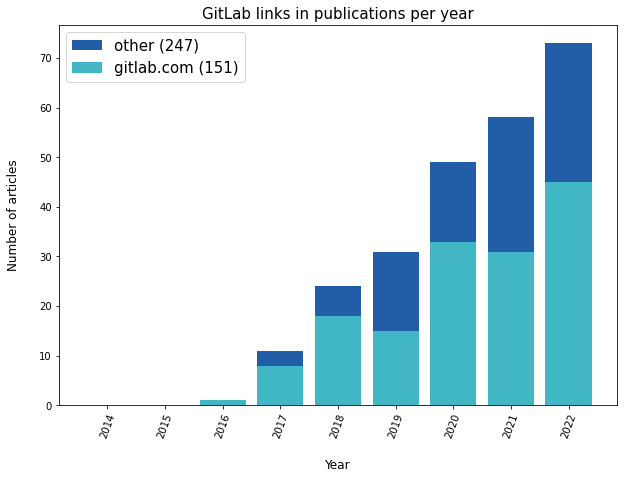

In [61]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2014, 2023))
values_gitlab = list(stats_gitlab.values())
values_gitlabcom = list(stats_gitlabcom.values())

ax.bar(years, values_gitlab, color='#225ea8')
ax.bar(years, values_gitlabcom, color='#41b6c4')

ax.legend([f"other ({sum(values_gitlab)})", 
           f"gitlab.com ({sum(values_gitlabcom)})"], loc = 'upper left', fontsize=15)

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('GitLab links in publications per year', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.savefig("../data/images/gitlab.png")
plt.show()